# Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

# DataGenerator

In [2]:
!pip install split-folders

import splitfolders
splitfolders.ratio('../input/concrete-crack-images-for-classification', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 40000 files [02:37, 253.26 files/s]


In [3]:
BATCH = 26
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [4]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

test_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

validation_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

Found 32000 files belonging to 2 classes.


2022-04-29 22:59:40.952123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 22:59:41.056713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 22:59:41.057459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 22:59:41.060060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [5]:
class_names = train_loader.class_names
print(class_names)

['Negative', 'Positive']


2022-04-29 22:59:50.901612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


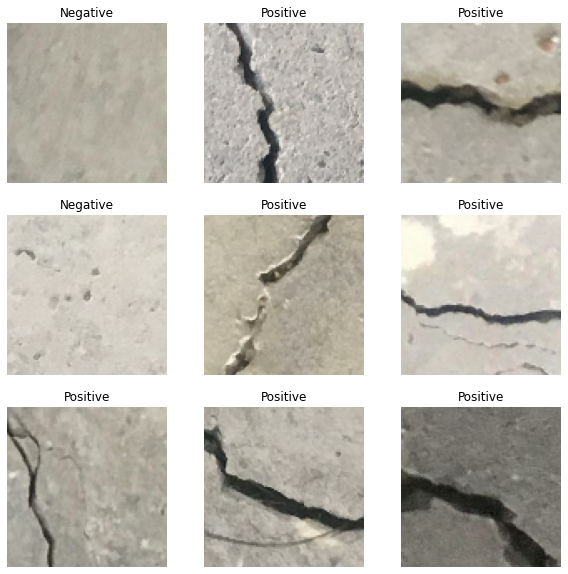

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_loader.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [8]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])


In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)       

In [10]:
epochs = 50
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50


2022-04-29 23:00:10.726977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1231/1231 [==============================] - 28s 9ms/step - loss: 0.0762 - accuracy: 0.9754 - val_loss: 0.0262 - val_accuracy: 0.9912
Epoch 2/50
1231/1231 [==============================] - 9s 7ms/step - loss: 0.0338 - accuracy: 0.9899 - val_loss: 0.0251 - val_accuracy: 0.9915
Epoch 3/50
1231/1231 [==============================] - 8s 7ms/step - loss: 0.0247 - accuracy: 0.9927 - val_loss: 0.0253 - val_accuracy: 0.9915
Epoch 4/50
1231/1231 [==============================] - 8s 7ms/step - loss: 0.0186 - accuracy: 0.9945 - val_loss: 0.0148 - val_accuracy: 0.9942
Epoch 5/50
1231/1231 [==============================] - 8s 7ms/step - loss: 0.0153 - accuracy: 0.9957 - val_loss: 0.0192 - val_accuracy: 0.9945
Epoch 6/50
1231/1231 [==============================] - 8s 7ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.0356 - val_accuracy: 0.9900
Epoch 7/50
1231/1231 [==============================] - 8s 7ms/step - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.0063 - val_accuracy: 0.9973
Ep

# Evaluation

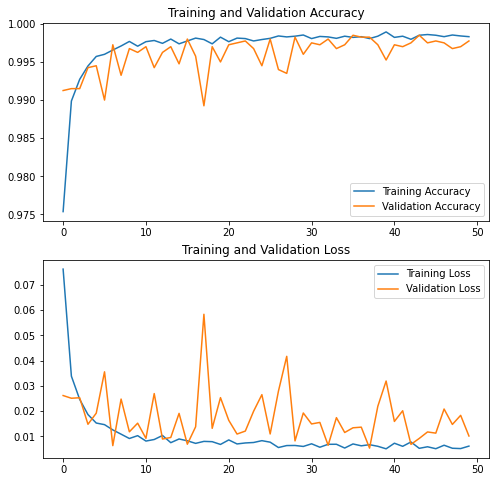

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test_dataset)

154/154 [==============================] - 3s 15ms/step - loss: 0.0338 - accuracy: 0.9985


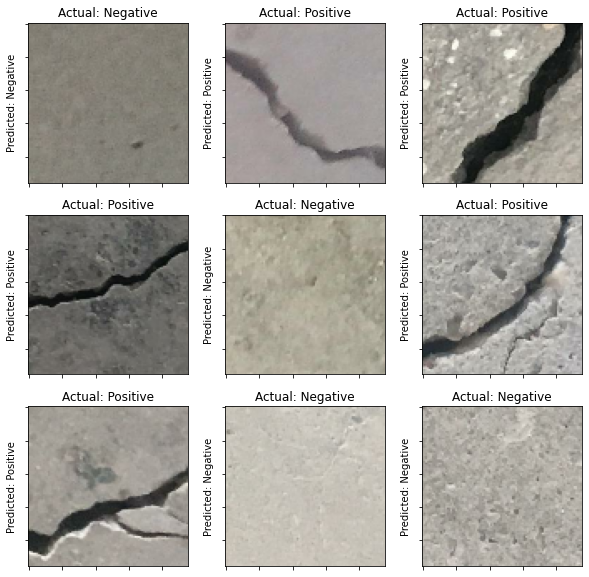

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

# Implemented by Muhammad Hanan Asghar